Progetto di Linguistica Computazionale II

[Vincenzo Sammartino](https://www.linkedin.com/in/vincenzo-sammartino-0339191a1/ "Vincenzo Sammartino") - matricola 599203

Corso di Laurea Magistrale in Informatica Umanistica

# Lettura e preprocessing dei dataset

In [1]:
!pip install conllu
!pip install transformers
!pip install evaluate
!pip install datasets
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.

In [2]:
#Import delle librerie necessarie
import pandas as pd
import re
import conllu
from conllu import parse

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MaxAbsScaler

from sklearn.dummy import DummyClassifier

from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer

from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


import sqlite3

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Librerie per le metriche
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from datasets import Dataset

import evaluate
from transformers import TrainingArguments


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Trasformo il file in modo da poter fare l'analisi con ProfilingUD

In [3]:
# Leggi il file TSV
file_tsv = "drive/MyDrive/LC2 Project/dati/haspeede2_dev_taskAB.tsv"
df = pd.read_csv(file_tsv, sep='\t', 
                 header=0, encoding='utf-8')
df.columns

Index(['id', 'text ', 'hs', 'stereotype'], dtype='object')

In [4]:
# Estrai la colonna 'text'
text_column = df['text ']
text_column

0       È terrorismo anche questo, per mettere in uno ...
1       @user @user infatti finché ci hanno guadagnato...
2       Corriere: Tangenti, Mafia Capitale dimenticata...
3       @user ad uno ad uno, perché quando i migranti ...
4       Il divertimento del giorno? Trovare i patrioti...
                              ...                        
6832    Gli stati nazionali devono essere pronti a rin...
6833    Il ministro dell'interno della Germania #Horst...
6834    #Salvini: In Italia troppi si sono montati la ...
6835    @user @user Chi giubila in buona fede non ha c...
6836    I giovani cristiani in #Etiopia sono indotti d...
Name: text , Length: 6837, dtype: object

In [5]:
output_file = "drive/MyDrive/LC2 Project/output_train.txt"
with open(output_file, 'w', encoding='utf-8') as f:
    for text in text_column:
        f.write(text + '\n')

Leggo ora il file in formato ConLL

In [6]:
with open("drive/MyDrive/LC2 Project/output_train.conllu", "r", encoding="utf-8") as f:
    text = f.read()

# Rimuovi URL
text = re.sub(r'URL', '', text)

# Rimuovi @user
text = re.sub(r'@user', '', text)

sentences_train = conllu.parse(text)


In [7]:
with open("drive/MyDrive/LC2 Project/output_test_news.conllu", "r", encoding="utf-8") as f:
    text = f.read()

# Rimuovi URL
text = re.sub(r'URL', '', text)

# Rimuovi @user
text = re.sub(r'@user', '', text)

sentences_test = conllu.parse(text)

#Unisco i due array per fare i dizionari successivamente
sentences = sentences_train + sentences_test


In [8]:
#Controllo che il numero di frasi sia uguale al numero di etichette
len(sentences_test)


500

Leggo il file TSV di test

In [10]:
# Leggi il file TSV
file_tsv = "drive/MyDrive/LC2 Project/dati/haspeede2-test_taskAB-news.tsv"
df = pd.read_csv(file_tsv, sep='\t', encoding='utf-8',
                 names=["id", "testo"])
testo_test = df['testo']


file_tsv = "drive/MyDrive/LC2 Project/dati/haspeede2_reference_taskAB-news.tsv"
df = pd.read_csv(file_tsv, sep='\t', encoding='utf-8',
                 names=["id", "testo", "hs", "stereotype"])

y_test_hs = df['hs'].values #etichette per il test (hate speech)

# etichette per il test (stereotype)
y_test_stereotypes = df['stereotype'].values

testo_test


0      Andate pure là, tanto quei fessi degli italian...
1      Che fine spero che faccia il killer nigeriano ...
2       Così i profughi ci svuotano i negozi a Pordenone
3      Così umiliano gli italiani e coccolano i cland...
4      Danno soldi ai clandestini, ma ai disabili inv...
                             ...                        
495    Sea Watch, il pm fa sbarcare i migranti. Salvi...
496    Il pm fa sbarcare i migranti Il capo leghista ...
497    Pisa, il poster di Salvini con i migranti fatt...
498    Sea Watch e lo sbarco del migrante con una sol...
499    Decreto Sicurezza Bis, multe più salate per ch...
Name: testo, Length: 500, dtype: object

In [11]:
output_file = "drive/MyDrive/LC2 Project/output_test_news.txt"
with open(output_file, 'w', encoding='utf-8') as f:
    for testo in testo_test:
        f.write(testo + '\n')


In [12]:
import numpy as np

with open('drive/MyDrive/LC2 Project/dati/haspeede2_dev_taskAB.tsv', 'r', encoding='utf-8') as file:
    # Salta la prima riga (header)
    file.readline()

    # Leggo le righe rimanenti
    lines = file.readlines()

    text = []
    hs = []
    stereotypes = []

    for line in lines:
        elements = line.split('\t')
        text.append(elements[1])
        hs.append(int(elements[2]))
        stereotypes.append(int(elements[3]))

    file.close()

text = np.array(text)
y_train_hs = np.array(hs)  # etichette per hate speech
y_train_stereotypes = np.array(stereotypes)  # etichette per stereotypes

# Neural Language Model

In [13]:
# Creo una variabile 'model' dove specificherò il modello da utilizzare
model_name = 'dbmdz/bert-base-italian-cased'

# Carico il modello
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(y_train_hs))

# Carico il tokenizzatore
tokenizer = AutoTokenizer.from_pretrained(model_name)


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

In [14]:
def conllu_sentences_to_strings(sentences):
    return [' '.join([token["form"] for token in sentence]) for sentence in sentences]

# Funzione che applica la tokenizzazione ai dati di training, dev e test



def tokenize(batch):
    tokens = tokenizer(batch['sentence'], padding=True,
                       truncation=True, max_length=512)
    tokens['label'] = [label for label in batch["label"]]

    return tokens


sentence_strings = conllu_sentences_to_strings(sentences)
testo_addestramento = pd.Series(sentence_strings)


# Convert pandas Series to Hugging Face Dataset
testo_addestramento_dataset = Dataset.from_pandas(
    testo_addestramento.to_frame(name="sentence"))

# Assign the Dataset object to a variable using the select method
train_dataset = testo_addestramento_dataset.select(range(0, 6839))
test_dataset = testo_addestramento_dataset.select(
    range(6839, len(testo_addestramento_dataset)))

train_dataset = train_dataset.add_column('label', y_train_hs)
test_dataset = test_dataset.add_column('label', y_test_hs)

# Use the map function with the batched keyword argument
train = train_dataset.map(tokenize, batched=True)
test = test_dataset.map(tokenize, batched=True)

# Set format
train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/6839 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [15]:
# Trainer
import transformers
import accelerate

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer



num_epochs = 5

training_args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=80,
    per_device_eval_batch_size=80,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
)


In [16]:
def compute_metrics(eval_pred):
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  return f1_metric.compute(predictions=predictions, references=labels, average="weighted")


In [17]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
#trainer.save_model("FINETUNED_MODEL")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,4.549600,1.783291,0.497001
2,1.092100,0.708583,0.667058
3,0.567900,0.775428,0.627217
4,0.468100,0.826674,0.602990
5,0.425800,0.871381,0.599508


TrainOutput(global_step=430, training_loss=1.4206835635872774, metrics={'train_runtime': 814.7155, 'train_samples_per_second': 41.972, 'train_steps_per_second': 0.528, 'total_flos': 2592508390237290.0, 'train_loss': 1.4206835635872774, 'epoch': 5.0})

<ipython-input-21-1a957348493b>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss,
<ipython-input-21-1a957348493b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss,
<ipython-input-21-1a957348493b>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss,
<ipython-input-21-1a957348493b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss,
<ipython-input-21-1a957348493b>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

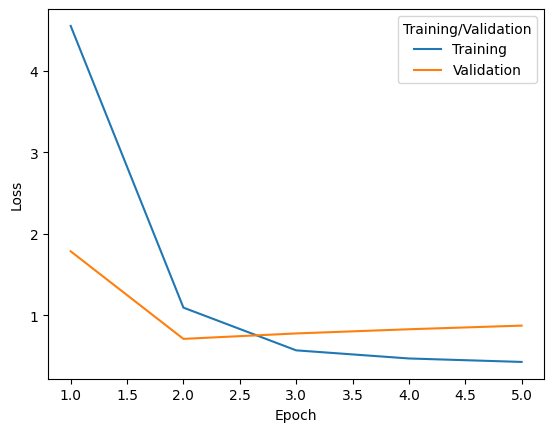

In [21]:
log_history = trainer.state.log_history

# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss,
                   "Training/Validation": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss,
                   "Training/Validation": "Validation"}, ignore_index=True)

# Lineplot della loss
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Training/Validation")
plt.savefig("hs_epoch_news.svg")


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       319
           1       0.74      0.30      0.43       181

    accuracy                           0.71       500
   macro avg       0.72      0.62      0.61       500
weighted avg       0.72      0.71      0.67       500


Confusion Matrix:


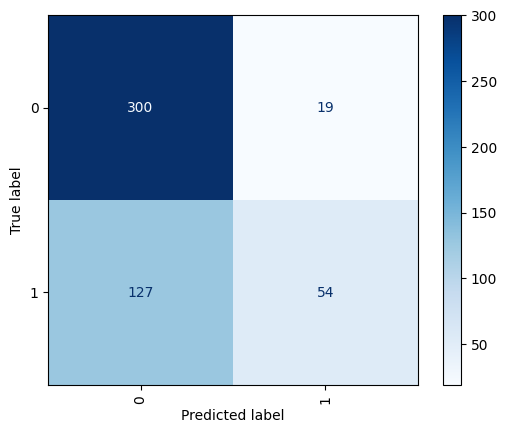

In [20]:
output_predictions = trainer.predict(test)
y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_test, y_pred)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues')

print("Classification Report:")
print(report)
print()

print("Confusion Matrix:")
print(cm)

plt.savefig("hs_cm_news.svg")